In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import helper

Exercise: Load images from the Cat_Dog_data/train folder, define a few transforms, then build the dataloader.

In [2]:
data_dir = './train'

transform =  transforms.Compose([transforms.Resize(255),transforms.CenterCrop(224),transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir,transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle = True)





<AxesSubplot:>

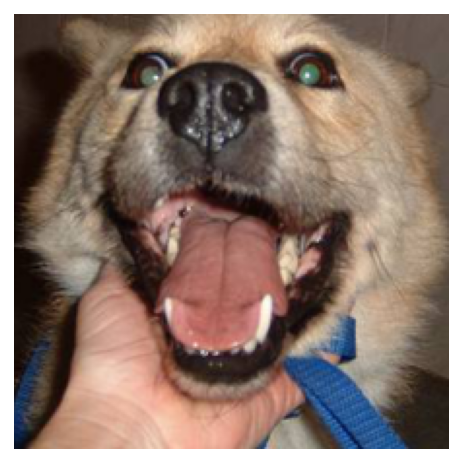

In [4]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
helper.imshow(images[5], normalize=False)

Exercise: Define transforms for training data and testing data below. Leave off normalization for now

In [8]:
data_dir = './'
train_transform = transforms.Compose([transforms.RandomRotation(180),transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),transforms.ToTensor()])
test_transform  = transforms.Compose([transforms.Resize(255),transforms.CenterCrop(224),transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + '/train',transform = train_transform)
test_data = datasets.ImageFolder(data_dir  + '/test1',transform = test_transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size= 64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size= 64, shuffle=True)

RuntimeError: Found 0 files in subfolders of: .//test1
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp

In [ ]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

We can load in a model such as DenseNet. Let's print out the model architecture so we can see what's going on.

In [6]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Asus/.cache\torch\checkpoints\densenet121-a639ec97.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
# Freezing parameters
for p in model.parameters():
    p.requires_grad = False

    
from collections import OrderedDict

Classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(1024,500)),('relu',nn.ReLU()),
                                       ('fc2',nn.Linear(500,2)),('output',nn.LogSoftmax(dim=1))]))

model.classifier = Classifier

With our model built, we need to train the classifier. However, now we're using a really deep neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses CUDA to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using model.to('cuda'). You can move them back from the GPU with model.to('cpu') which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [9]:
import time

for device in ['cpu','cuda']:
    
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr= 0.001) #Passing only the parameters of the classifier as only they have to be changed
    
    model.to(device)
    
    for i , (inputs,labels) in enumerate (trainloader):
        inputs , labels = inputs.to(device) , labels.to(labels)
        
        start = time.time()
        
        outputs = model.forward(inputs)
        loss = criterion(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

NameError: name 'trainloader' is not defined